# Training a Model to Predict US Congress Votes

## 1.: Creating an aggregate DataFrame

In [43]:
import pandas as pd

In [46]:
attendance_df = pd.read_csv('./data/attendance_2024.csv')
senators_df = pd.read_csv('./data/senators_2024.csv')
vote_details_df = pd.read_csv('./data/vote_details_2024.csv')

senators_df.rename(columns={senators_df.columns[0]: 'senator_number'}, inplace=True)

attendance_df.head()

,vote_number,senator_number,vote
0,255,0,Yea
1,255,1,Nay
2,255,2,Yea
3,255,3,Nay
4,255,4,Yea


In [47]:
mapping = {
    'Bill Passed': 1,
    'Nomination Confirmed': 1,
    'Cloture Motion Agreed to': 1,
    'Motion to Proceed Rejected': 0,
    'Amendment Rejected': 0,
    'Cloture Motion Rejected': 0,
    'Cloture on the Motion to Proceed Rejected': 0,
    'Motion Agreed to': 1,
    'Point of Order Well Taken': 1,
    'Joint Resolution Passed': 1,
    'Joint Resolution Defeated': 0,
    'Motion to Table Failed': 0,
    'Motion to Proceed Agreed to': 1,
    'Cloture on the Motion to Proceed Agreed to': 1,
    'Bill Defeated': 0,
    'Motion to Adjourn Agreed to': 1,
    'Motion to Adjourn Rejected': 0,
    'Motion Rejected': 0,
    'Motion to Table Agreed to': 1,
    'Motion to Refer Rejected': 0,
    'Motion for Attendance Agreed to': 1,
    'Motion to Discharge Rejected': 0,
    'Veto Sustained': 0,
    'Amendment Agreed to': 1,
    'Motion to Reconsider Agreed to': 1
}

vote_details_df['passed'] = vote_details_df['result'].map(mapping)

In [48]:
vote_and_attendance_df = pd.merge(vote_details_df, attendance_df, on='vote_number', how='inner')

aggregated_df = pd.merge(vote_and_attendance_df, senators_df, on='senator_number', how='inner')

aggregated_df.head()

,vote_number,vote_date,result,measure_number,measure_title,passed,senator_number,vote,senator_name,party,state
0,255,"September 25, 2024, 05:18 PM",Bill Passed,H.R. 9747,A bill making continuing appropriations and ex...,1,0,Yea,Baldwin,D,WI
1,255,"September 25, 2024, 05:18 PM",Bill Passed,H.R. 9747,A bill making continuing appropriations and ex...,1,1,Nay,Bennet,D,CO
2,255,"September 25, 2024, 05:18 PM",Bill Passed,H.R. 9747,A bill making continuing appropriations and ex...,1,2,Yea,Blumenthal,D,CT
3,255,"September 25, 2024, 05:18 PM",Bill Passed,H.R. 9747,A bill making continuing appropriations and ex...,1,3,Nay,Boozman,R,AR
4,255,"September 25, 2024, 05:18 PM",Bill Passed,H.R. 9747,A bill making continuing appropriations and ex...,1,4,Yea,Britt,R,AL


In [49]:
aggregated_df.drop(columns = ['vote_date', 'measure_number',
                    'measure_title', 'senator_number',
                    'senator_name', 'state' ], inplace=True)

aggregated_df['was_passed'] = aggregated_df['result'].map(mapping)
#aggregated_df.head(50)

In [50]:
# Step 1: Simplify vote column
aggregated_df['vote'] = aggregated_df['vote'].replace({'Yea': 'Yes', 'Nay': 'No', 'Present': 'Not Voting'})

# Step 2: Create a pivot table to calculate the number of Yes/No votes for each party
pivot = aggregated_df.pivot_table(index='vote_number', columns=['party', 'vote'], aggfunc='size', fill_value=0)

# Step 3: Calculate total number of votes per party
party_totals = pivot.T.groupby(level=0).sum().T

# Step 4: Calculate the percentage of Yes and No votes for each party
percentages = pivot.div(party_totals, axis=0)

# Step 5: Flatten the multi-level columns
percentages.columns = [f'{party} {vote}%' for party, vote in percentages.columns]

# Step 6: Rename the total votes per party to indicate members
members = party_totals.rename(columns=lambda x: f'{x} Members')

# Step 7: Combine the percentages and members into one DataFrame
final_df = pd.concat([percentages, members], axis=1)

# Step 8: Add the 'Result (Pass/Fail)' column based on the 'was_passed' value
final_df['Result'] = aggregated_df.groupby('vote_number')['was_passed'].first()


# Save the final DataFrame to a CSV file
final_df.to_csv('./data/dataset.csv', index=False)

## Creating the model
### 1.: Sci-kit learn Random Forest

In [16]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Reimport, so the model building part can be run without the previous cells
import pandas as pd

In [26]:
train_data = pd.read_csv('./data/dataset.csv')

In [27]:
# Split the data into features (X) and target (y)
features = train_data.drop('Result', axis=1)
target = train_data['Result']

# Split the data into training and test sets
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3)

In [28]:
random_forest = RandomForestClassifier()
random_forest.fit(feature_train, target_train)

RandomForestClassifier()

In [29]:
predicted_values = random_forest.predict(feature_test)

In [30]:
accuracy = accuracy_score(target_test, predicted_values)
print("Accuracy:", accuracy)

Accuracy: 0.935064935064935


### Hyperparameter Tuning

In [31]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}


optimized_random_forest = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(optimized_random_forest,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(feature_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E5DA0C320>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E5DA9C680>})

In [32]:
best_model = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 370}


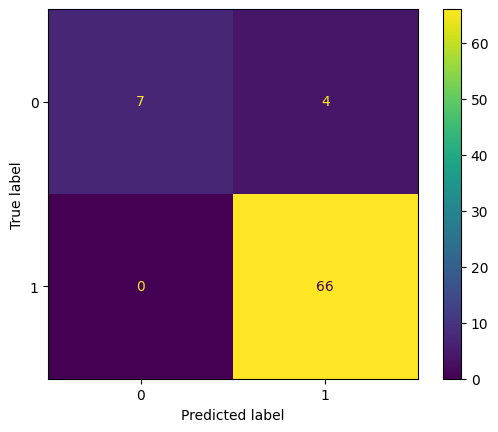

In [33]:
# Generate predictions with the best model
y_pred = best_model.predict(feature_test)

# Create the confusion matrix
cm = confusion_matrix(target_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [34]:
y_pred = best_model.predict(feature_test)

accuracy = accuracy_score(target_test, y_pred)
precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.948051948051948
Precision: 0.9428571428571428
Recall: 1.0


### 2.: Sci-kit Learn Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Reimport, so the model building part can be run without the previous cells
import pandas as pd

In [2]:
train_data = pd.read_csv('./data/dataset.csv')

In [3]:
# Split the data into features (X) and target (y)
features = train_data.drop('Result', axis=1)
target = train_data['Result']

# Split the data into training and test sets
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3)

In [4]:
logreg = LogisticRegression()

In [5]:
logreg.fit(feature_train, target_train)

target_pred_logreg = logreg.predict(feature_test)

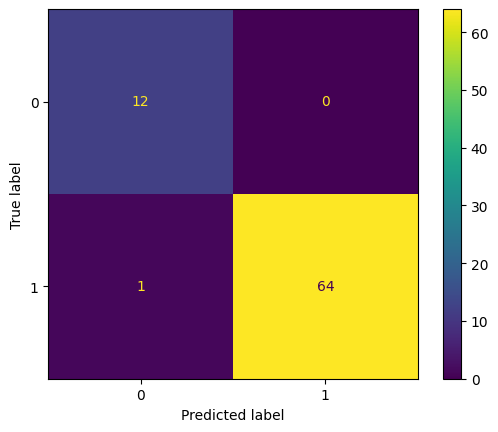

In [6]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(target_test, target_pred_logreg)

ConfusionMatrixDisplay(confusion_matrix=cnf_matrix).plot();

In [7]:
accuracy = accuracy_score(target_test, target_pred_logreg)
precision = precision_score(target_test, target_pred_logreg)
recall = recall_score(target_test, target_pred_logreg)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.987012987012987
Precision: 1.0
Recall: 0.9846153846153847
